# Bank Churn Dataset

# EDA

In [8]:
from random import sample
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split

zip_file = zipfile.ZipFile('playground-series-s4e1.zip')
train_data = zip_file.open('train.csv')
test_data = zip_file.open('test.csv')
sample_submission = zip_file.open('sample_submission.csv')

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
sample_df = pd.read_csv(sample_submission)

In [9]:
# make id the index
train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)

# drop useless columns like customerId and Surname
train_df.drop(['CustomerId', 'Surname'], axis=1, inplace=True) 
test_df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


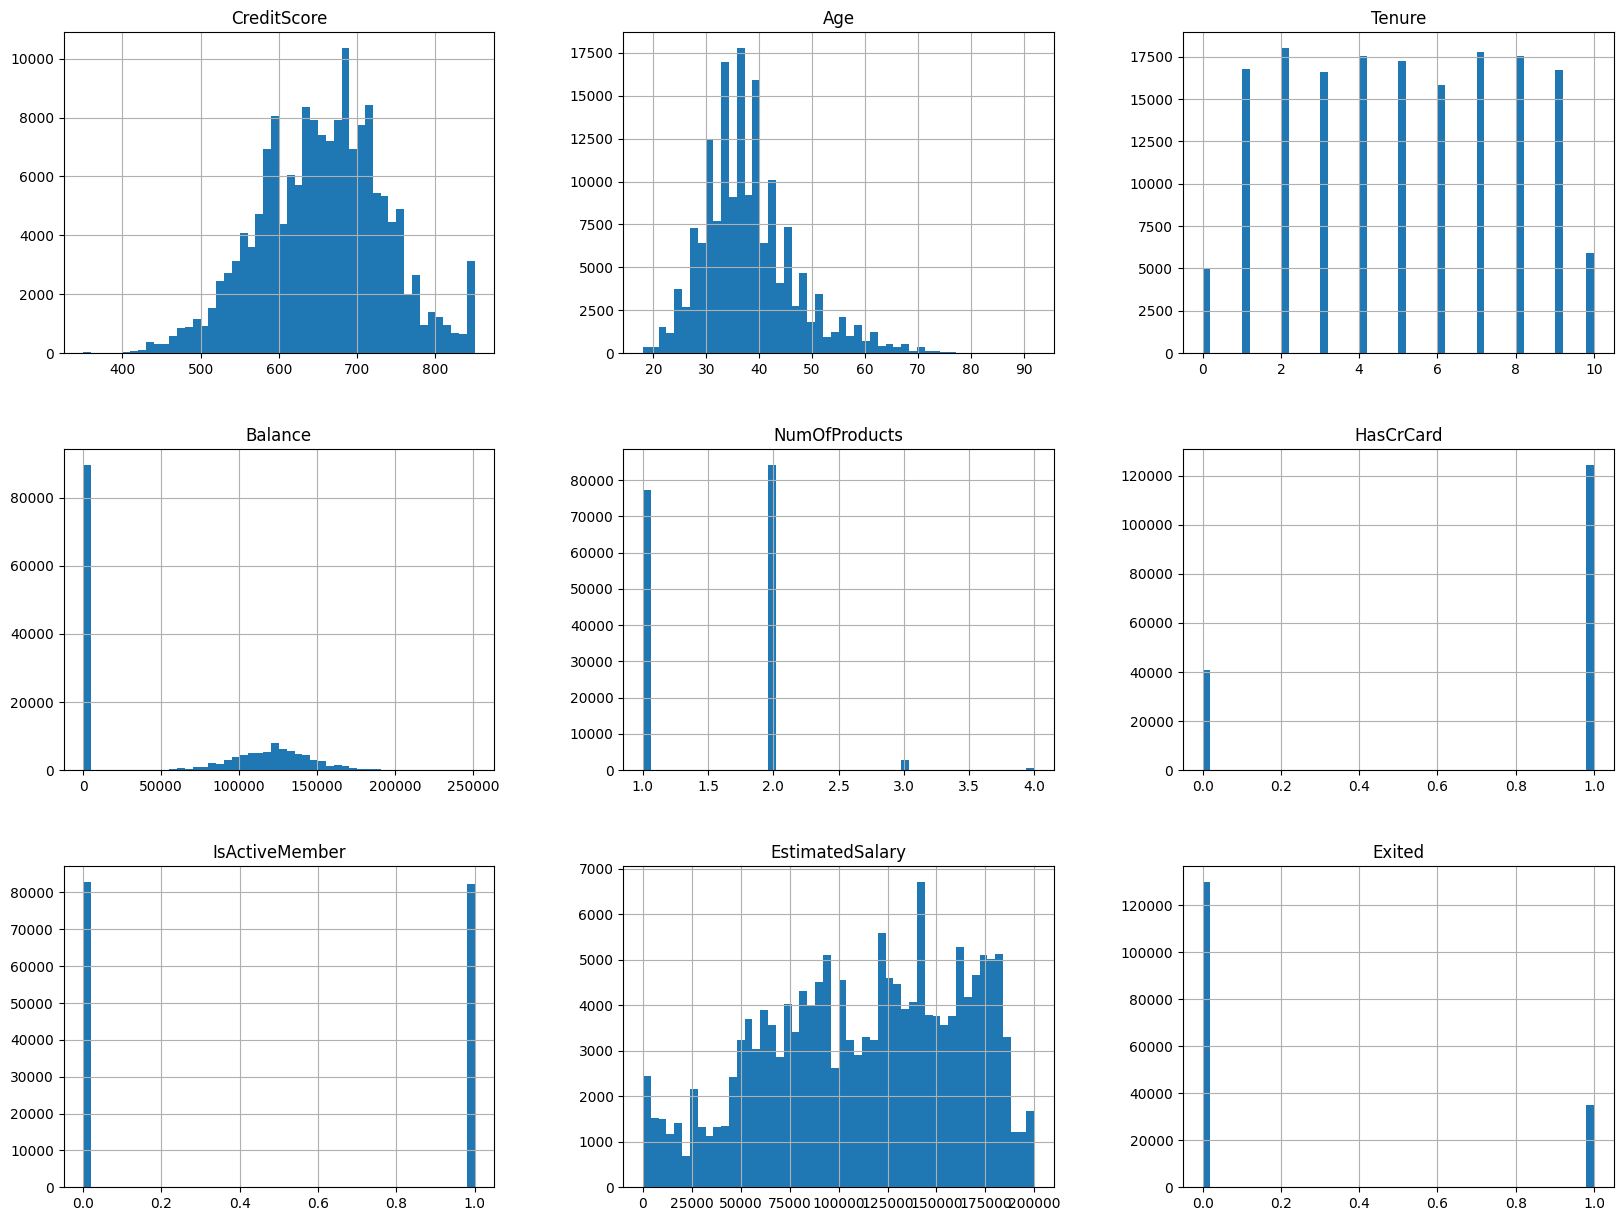

In [10]:
# plot different histograms of CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited
import matplotlib.pyplot as plt

train_df.hist(bins=50, figsize=(20,15))
plt.show()

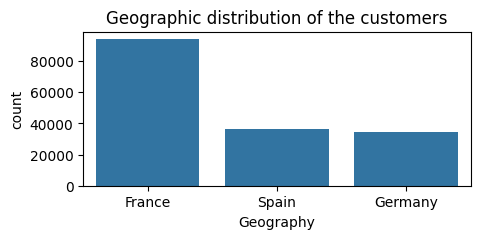

In [11]:
# Plot the Geographic distribution of the customers
import seaborn as sns

# Make it a small graph
plt.figure(figsize=(5,2))
sns.countplot(x='Geography', data=train_df)
plt.title('Geographic distribution of the customers')
plt.show()

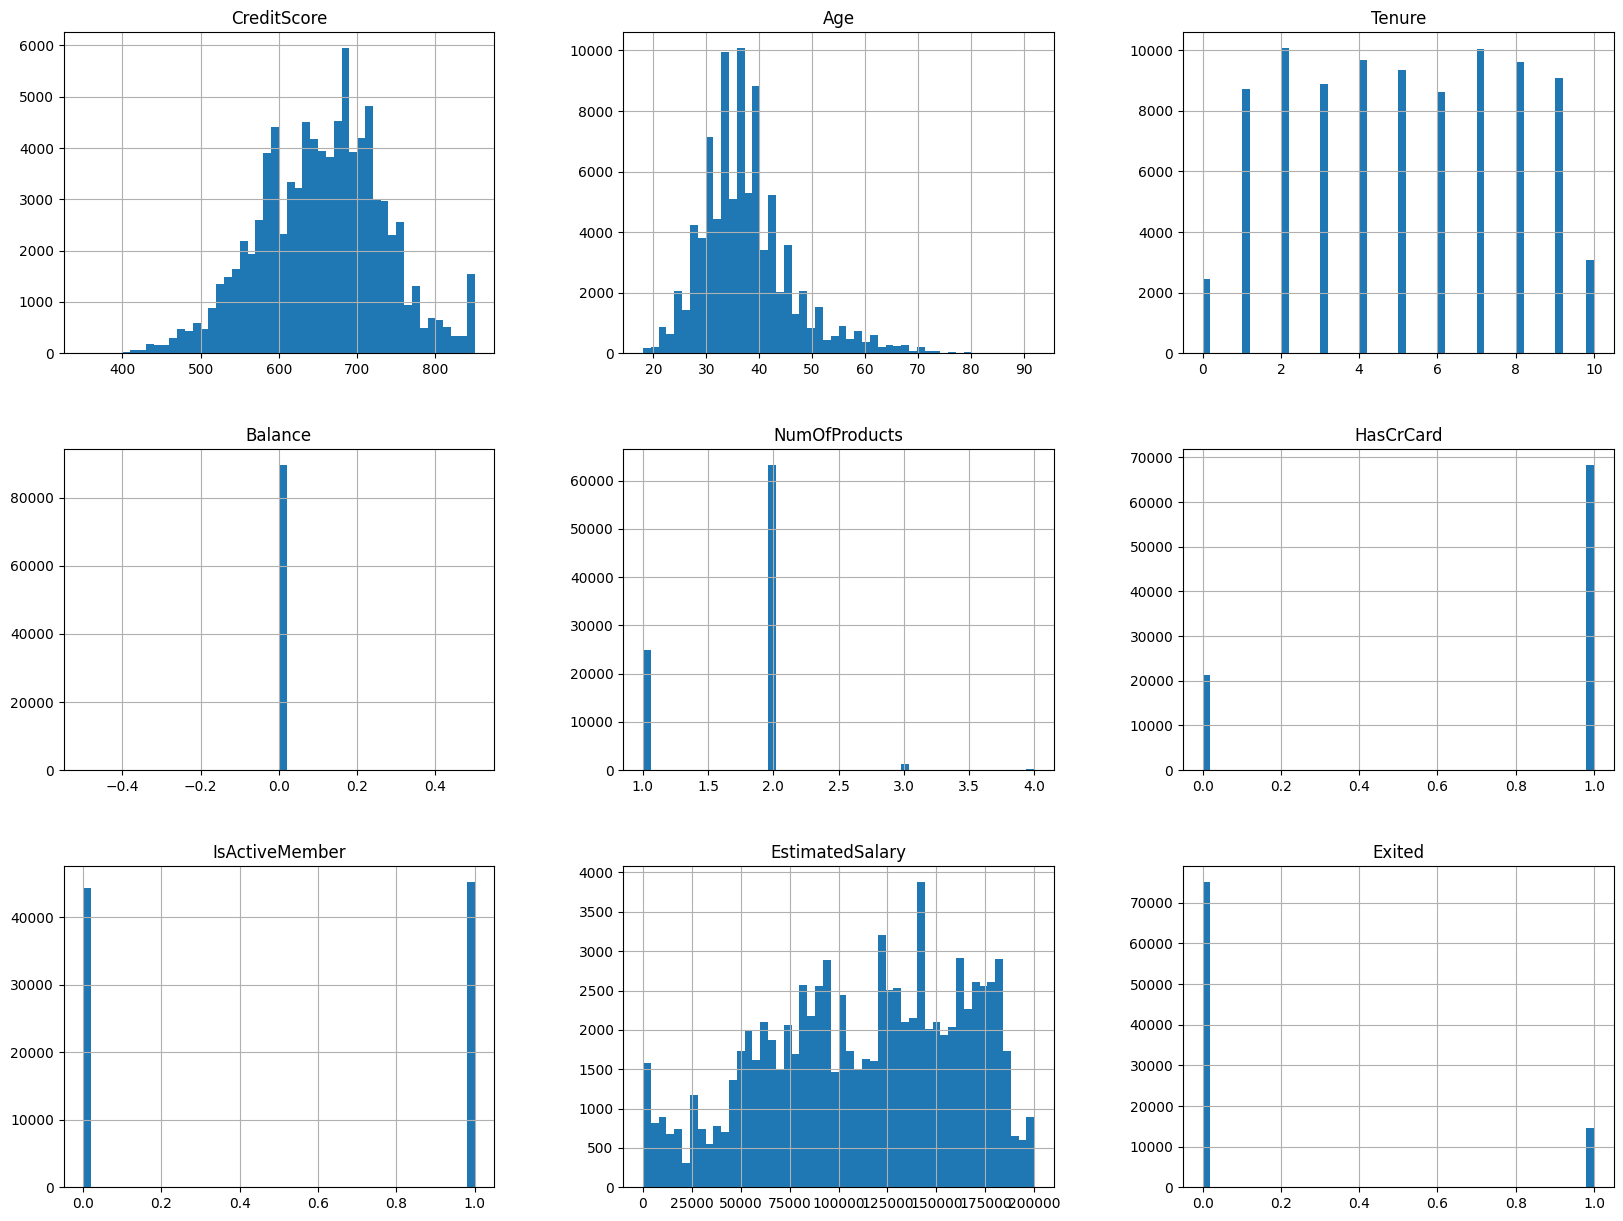

In [12]:
# Make the histogram for all columns again but only selecting those with balance equal to 0
train_df[train_df['Balance']==0].hist(bins=50, figsize=(20,15))
plt.show()

In [13]:
# count the number of people with balance equal to 0 vs the number of people with balance greater than 0
print('Number of people with balance equal to 0: ', len(train_df[train_df['Balance']==0]))
print('Number of people with balance greater than 0: ', len(train_df[train_df['Balance']>0]))

Number of people with balance equal to 0:  89648
Number of people with balance greater than 0:  75386


/!\ Watchout, dataset is imbalanced, lot less `Exited` than otherwise

# Logistic

## NOT normalized

In [44]:
# Make lgistic regression model
from sklearn.linear_model import LogisticRegression

# Make dummy data for Geography and Gender columns
train_df = pd.get_dummies(train_df, columns=['Geography', 'Gender'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Geography', 'Gender'], drop_first=True)

# Split the data into train and test
X = train_df.drop('Exited', axis=1)
y = train_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model using AUROC
from sklearn.metrics import roc_auc_score

print('AUROC score: ', roc_auc_score(y_test, predictions))

AUROC score:  0.5394437981062071


In [45]:
# count nb of 0s in predictions and in y_test
print('Total number of records: ', len(predictions))
print('Number of 0s in predictions: ', len(predictions[predictions==0]))
print('Number of 0s in predictions: ', len(y_test[y_test==0]))

Total number of records:  33007
Number of 0s in predictions:  31281
Number of 0s in predictions:  25947


Feature: 0, Score: -0.00617
Feature: 1, Score: 0.06641
Feature: 2, Score: -0.00204
Feature: 3, Score: 0.00000
Feature: 4, Score: -0.00253
Feature: 5, Score: -0.00034
Feature: 6, Score: -0.00268
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.00143
Feature: 9, Score: -0.00040
Feature: 10, Score: -0.00187


<BarContainer object of 11 artists>

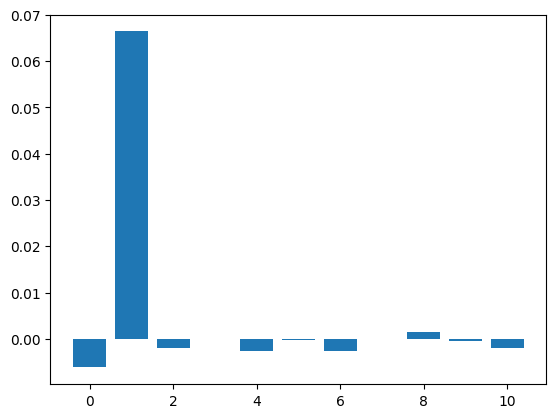

In [46]:
# get importance of each feature
importance = model.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)

## Normalized

In [18]:
# Train a logistic regression model again but normalizing the data
# except the categorical variables
from sklearn.preprocessing import StandardScaler

# Make a copy of the data
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Get the columns to normalize
cols_to_norm = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Normalize the data
train_df_norm[cols_to_norm] = StandardScaler().fit_transform(train_df_norm[cols_to_norm])
test_df_norm[cols_to_norm] = StandardScaler().fit_transform(test_df_norm[cols_to_norm])

# Split the data into train and test
X = train_df_norm.drop('Exited', axis=1)
y = train_df_norm['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get probabilities
probabilities = model.predict_proba(X_test)

# probabilities[:, 1] gives the probabilities of the positive class
print(probabilities[:, 1])


NameError: name 'LogisticRegression' is not defined

In [50]:
# Now retrain the model on ALL the data and export the predictions of test_df 
# by keeping the index and naming the header Exited
model = LogisticRegression()
model.fit(X, y)

predictions = model.predict_proba(test_df_norm)
predictions = predictions[:, 1]

# Make a dataframe with the predictions
predictions_df = pd.DataFrame(predictions, index=test_df.index, columns=['Exited'])
predictions_df.head()

,Exited
id,
165034,0.023482
165035,0.578350
165036,0.151329
165037,0.206816
165038,0.422852


In [51]:
# export to csv
predictions_df.to_csv('predictions.csv')

# Random Forest

In [21]:
# Build a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Make a copy of the data
train_df_rf = train_df.copy()
test_df_rf = test_df.copy()

# Split the data into train and test
X = train_df_rf.drop('Exited', axis=1)
y = train_df_rf['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)


NameError: name 'roc_auc_score' is not defined

In [22]:
from sklearn.metrics import roc_auc_score

# Evaluate the model using AUROC
print('AUROC score: ', roc_auc_score(y_test, predictions))

AUROC score:  0.7367527077955756


In [30]:
# Retrain the model on all the data
model = RandomForestClassifier()
model.fit(X, y)

# Get probabilities on the test data
probabilities = model.predict_proba(test_df)

# make into pandas df
probabilities_df = pd.DataFrame(probabilities[:, 1], index=test_df.index, columns=['Exited'])

# export to csv
probabilities_df.to_csv('predictions_rf.csv')

In [32]:
len(probabilities_df)

110023

- graduent boosting
- svm
- nn

# Gradient Boosting

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming that your data is in a DataFrame called df, and your target variable is 'Exited'
X = train_df.drop('Exited', axis=1)
y = train_df['Exited']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix for more efficiency
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters
param = {
    'max_depth': 3,  # maximum depth of each tree
    'eta': 0.3,  # learning rate
    'objective': 'binary:logistic',  # binary classification
    'nthread': 4,  # number of CPU threads to use
    'eval_metric': 'auc'  # evaluation metric
}
num_round = 20  # number of boosting rounds

# Train the model
bst = xgb.train(param, dtrain, num_round)

# Make predictions
preds_proba = bst.predict(dtest)
preds_binary = [1 if pred > 0.5 else 0 for pred in preds_proba]

# Evaluate the model
auroc = roc_auc_score(y_test, preds_proba)
print("AUROC: %.2f" % auroc)

AUROC: 0.89


In [39]:
# retrain the model with all the data
dtrain = xgb.DMatrix(X, label=y)
bst = xgb.train(param, dtrain, num_round)

# Make predictions on the test data
dtest = xgb.DMatrix(test_df)
preds_proba = bst.predict(dtest)

# make preds proba into df and export to csv
preds_proba_df = pd.DataFrame(preds_proba, index=test_df.index, columns=['Exited'])
preds_proba_df.to_csv('predictions_xgb.csv')

# SVM